In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

# Create DataFrame 

In [35]:
def create_dataset(folders, n = None): 
    X = []
    
    for folder in folders:
        files_s = glob.glob(f"../raw_data/{folder}/*all*.tif")
        if n is None:
            n = len(files_s)
        for file in files_s[:n]:
            filename = os.path.basename(f"../raw_data/{folder}/{file}")
            file_id, date = filename.split('_all_bands_')
            date = date.replace('.tif','')
    
            img = rasterio.open(file)
            # Compute ndvi mean, median, std
            ndvi = (img.read(8)-img.read(4))/(img.read(8) + img.read(4))
            ndvi_ = np.nan_to_num(ndvi, nan=-1)
            ndvi_values = np.array([x for x in ndvi_.flatten() if x != -1])
            ndvi_mean = ndvi_values.mean()
            ndvi_median = np.median(ndvi_values)
            ndvi_std = np.std(ndvi_values)
            
            # Compute mi mean, median, std
            mi = (img.read(8)-img.read(11))/(img.read(8) + img.read(11))
            mi_ = np.nan_to_num(mi, nan=-1)
            mi_values =np.array([x for x in mi_.flatten() if x != -1])
            mi_mean = mi_values.mean()
            mi_median = np.median(mi_values)
            mi_std = np.std(mi_values)
            
            # Compute Cb1 mean, median, std
            band_combo_1 = img.read(7) + img.read(6) + img.read(4)
            bc1_ = np.nan_to_num(band_combo_1, nan=-1)
            bc1_values =np.array([x for x in bc1_.flatten() if x != -1])
            bc1_mean = bc1_values.mean()
            bc1_median = np.median(bc1_values)
            bc1_std = np.std(bc1_values)
            
            # Compute Cb2 mean, median, std
            band_combo_2 = img.read(11) + img.read(8) + img.read(2)
            bc2_ = np.nan_to_num(band_combo_2, nan=-1)
            bc2_values =np.array([x for x in bc2_.flatten() if x != -1])
            bc2_mean= bc2_values.mean()
            bc2_median= np.median(bc2_values)
            bc2_std= np.std(bc2_values)
            
            # Compute Cb3 mean, median, std
            band_combo_3 = (img.read(3)-img.read(8))/(img.read(3)+img.read(8))
            bc3_ = np.nan_to_num(band_combo_3, nan=-1)
            bc3_values =np.array([x for x in bc3_.flatten() if x != -1])
            bc3_mean= bc3_values.mean()
            bc3_median= np.median(bc3_values)
            bc3_std= np.std(bc3_values)
            
            # Compute Cb4 mean, median, std
            band_combo_4 = img.read(12) + img.read(8) + img.read(4)
            bc4_ = np.nan_to_num(band_combo_4, nan=-1)
            bc4_values =np.array([x for x in bc4_.flatten() if x != -1])
            bc4_mean= bc4_values.mean()
            bc4_median= np.median(bc4_values)
            bc4_std= np.std(bc4_values)
            
            # Compute Cb5 mean, median, std
            band_combo_5 = img.read(4) + img.read(3) + img.read(2)
            bc5_ = np.nan_to_num(band_combo_5, nan=-1)
            bc5_values =np.array([x for x in bc5_.flatten() if x != -1])
            bc5_mean= bc5_values.mean()
            bc5_median= np.median(bc5_values)
            bc5_std= np.std(bc5_values)
            
            #Feature Dictionary
            b_dict = {'date':date,'file_id':file_id,'target': folder,\
                      'ndvi_mean': ndvi_mean,'ndvi_median': ndvi_median,'ndvi_std': ndvi_std,\
                      'mi_mean': mi_mean,'mi_median': mi_median,'mi_std': mi_std,\
                      'bc1_mean': bc1_mean,'bc1_median': bc1_median,'bc1_std': bc1_std,\
                      'bc2_mean': bc2_mean,'bc2_median': bc2_median,'bc2_std': bc2_std,\
                      'bc3_mean': bc3_mean,'bc3_median': bc3_median,'bc3_std': bc3_std,\
                      'bc4_mean': bc4_mean,'bc4_median': bc4_median,'bc4_std': bc4_std,\
                      'bc5_mean': bc5_mean,'bc5_median': bc5_median,'bc5_std': bc5_std}
            
            for band in range(1,14):
#               b_dict[f'b{band}'] = img.read(band).flatten()
                b_dict[f'b{band}_mean'] = img.read(band).flatten().mean()
                b_dict[f'b{band}_median'] = np.median(img.read(band).flatten())
                b_dict[f'b{band}_std'] = np.std(img.read(band).flatten())
            X.append(b_dict)      
            img.close()
    df = pd.DataFrame(X)
    
    #Add month columns, sort by month
    df['month'] = pd.DatetimeIndex(df['date']).month
#     df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df.sort_values(by=['month'])
    
    return df

In [20]:
folders = ['rice_1y', 'sugarcane']
df = create_dataset(folders) 
df.head()

<ipython-input-19-0ba1b5f92f23>:15: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (img.read(8)-img.read(4))/(img.read(8) + img.read(4))
<ipython-input-19-0ba1b5f92f23>:23: RuntimeWarning: invalid value encountered in true_divide
  mi = (img.read(8)-img.read(11))/(img.read(8) + img.read(11))
<ipython-input-19-0ba1b5f92f23>:47: RuntimeWarning: invalid value encountered in true_divide
  band_combo_3 = (img.read(3)-img.read(8))/(img.read(3)+img.read(8))


,date,file_id,target,ndvi_mean,ndvi_median,ndvi_std,mi_mean,mi_median,mi_std,bc1_mean,...,b11_mean,b11_median,b11_std,b12_mean,b12_median,b12_std,b13_mean,b13_median,b13_std,month
886,2021-01-10,id_6094f75af85c5e001b870a52,rice_1y,0.720450,0.726511,0.025422,0.338732,0.342153,0.018440,4806.410884,...,1177.865306,2093.0,1078.710526,663.726531,1192.0,607.631602,0.544218,1.0,0.498041,1
1416,2021-01-05,id_60a09545f85c5e001b8714ba,rice_1y,0.050890,0.050000,0.006207,0.258570,0.259185,0.007349,5254.888889,...,1063.948560,0.0,1738.811091,817.359053,0.0,1335.629747,0.272634,0.0,0.445314,1
407,2021-01-10,id_60a098fbf85c5e001b8714db,rice_1y,0.385632,0.378166,0.042201,0.245925,0.251608,0.032063,969.441198,...,238.759679,0.0,427.112672,168.390066,0.0,301.069282,0.240321,0.0,0.427279,1
2078,2021-01-24,Name_5f2a51ce868954001c94d1f4,sugarcane,0.194315,0.182281,0.035539,10.616879,10.010155,1.769372,4565.833333,...,2825.596154,3409.0,1739.000522,2696.056090,3083.0,1707.714406,0.745192,1.0,0.435753,1
1423,2021-01-20,id_6094c0dcf85c5e001b870958,rice_1y,0.919154,0.926241,0.029616,0.437778,0.442913,0.021909,4875.832817,...,1052.777090,1484.0,719.127597,501.095975,704.0,343.785006,0.684211,1.0,0.464830,1


In [3]:
# Save df and load df from csv 
df = pd.read_csv('dataframe4.csv')
df

,date,file_id,target,ndvi_mean,ndvi_median,ndvi_std,mi_mean,mi_median,mi_std,bc1_mean,...,b11_mean,b11_median,b11_std,b12_mean,b12_median,b12_std,b13_mean,b13_median,b13_std,month
0,2020-07-03,id_6054a1b558a7cd00480009d1,sugarcane,0.034759,0.034592,0.008400,0.286780,0.286444,0.006628,14860.739683,...,2722.539683,3492.0,1510.809549,1582.393651,2035.0,878.217826,0.765079,1.0,0.423949,7
1,2020-07-03,id_6054a1b458a7cd0048000992,sugarcane,0.075362,0.074598,0.006388,0.287925,0.288526,0.004558,11321.767857,...,2208.937500,2932.0,1275.926031,1302.991071,1734.0,752.846331,0.750000,1.0,0.433013,7
2,2020-07-03,id_6054a1b558a7cd00480009ec,sugarcane,0.012111,0.011823,0.003235,0.303405,0.303554,0.003345,15858.610586,...,2809.338374,3453.0,1348.118977,1942.035917,2387.0,932.018660,0.812854,1.0,0.390028,7
3,2020-07-03,Name_5f2a5324868954001c94d201,sugarcane,0.250802,0.253114,0.014855,0.264690,0.266351,0.011328,5063.663810,...,1154.457143,0.0,1374.713478,889.934286,0.0,1059.201426,0.414286,0.0,0.492598,7
4,2020-07-03,id_6054a1b558a7cd00480009c5,sugarcane,0.033627,0.033637,0.002466,0.324563,0.324709,0.002784,17477.125850,...,2967.547619,3363.0,1091.051342,1645.125850,1862.0,604.951059,0.880952,1.0,0.323845,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7776,2021-06-30,Name_5f2a51ce868954001c94d1f4,sugarcane,0.092526,0.092308,0.006980,0.188140,0.188512,0.004292,10628.815705,...,2588.721154,3468.0,1514.225743,2124.169872,2842.0,1242.387354,0.745192,1.0,0.435753,6
7777,2021-06-30,id_60628e67f85c5e001b86ec15,sugarcane,0.281448,0.271823,0.112407,0.480695,0.145423,2.667427,4273.222488,...,1239.755981,1237.0,466.633144,1017.566986,1056.0,358.653518,0.904306,1.0,0.294171,6
7778,2021-06-30,id_6054a1b558a7cd00480009d1,sugarcane,0.464160,0.465889,0.056053,2.017831,0.084464,4.059035,5720.292063,...,2266.203175,2864.0,1266.575379,1531.273016,1933.0,861.377572,0.765079,1.0,0.423949,6
7779,2021-06-30,id_6054a1b558a7cd00480009aa,sugarcane,0.465237,0.461804,0.081919,0.149463,0.140629,0.052326,6033.383333,...,1987.266667,2581.0,1302.297148,1354.583333,1730.0,904.004642,0.708333,1.0,0.454530,6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7781 entries, 0 to 7780
Data columns (total 58 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7781 non-null   object 
 1   file_id      7781 non-null   object 
 2   target       7781 non-null   object 
 3   ndvi_mean    7781 non-null   float64
 4   ndvi_median  7781 non-null   float64
 5   ndvi_std     7781 non-null   float64
 6   mi_mean      7781 non-null   float64
 7   mi_median    7781 non-null   float64
 8   mi_std       7781 non-null   float64
 9   bc1_mean     7781 non-null   float64
 10  bc1_median   7781 non-null   float64
 11  bc1_std      7781 non-null   float64
 12  bc2_mean     7781 non-null   float64
 13  bc2_median   7781 non-null   float64
 14  bc2_std      7781 non-null   float64
 15  bc3_mean     7781 non-null   float64
 16  bc3_median   7781 non-null   float64
 17  bc3_std      7781 non-null   float64
 18  b1_mean      7781 non-null   float64
 19  b1_med

In [5]:
df.keys()

Index(['date', 'file_id', 'target', 'ndvi_mean', 'ndvi_median', 'ndvi_std',
       'mi_mean', 'mi_median', 'mi_std', 'bc1_mean', 'bc1_median', 'bc1_std',
       'bc2_mean', 'bc2_median', 'bc2_std', 'bc3_mean', 'bc3_median',
       'bc3_std', 'b1_mean', 'b1_median', 'b1_std', 'b2_mean', 'b2_median',
       'b2_std', 'b3_mean', 'b3_median', 'b3_std', 'b4_mean', 'b4_median',
       'b4_std', 'b5_mean', 'b5_median', 'b5_std', 'b6_mean', 'b6_median',
       'b6_std', 'b7_mean', 'b7_median', 'b7_std', 'b8_mean', 'b8_median',
       'b8_std', 'b9_mean', 'b9_median', 'b9_std', 'b10_mean', 'b10_median',
       'b10_std', 'b11_mean', 'b11_median', 'b11_std', 'b12_mean',
       'b12_median', 'b12_std', 'b13_mean', 'b13_median', 'b13_std', 'month'],
      dtype='object')

In [6]:
df2 = df.copy()
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')
df2 = df2.sort_values(by=['date'])
df2

,date,file_id,target,ndvi_mean,ndvi_median,ndvi_std,mi_mean,mi_median,mi_std,bc1_mean,...,b11_mean,b11_median,b11_std,b12_mean,b12_median,b12_std,b13_mean,b13_median,b13_std,month
0,2020-07-03,id_6054a1b558a7cd00480009d1,sugarcane,0.034759,0.034592,0.008400,0.286780,0.286444,0.006628,14860.739683,...,2722.539683,3492.0,1510.809549,1582.393651,2035.0,878.217826,0.765079,1.0,0.423949,7
23,2020-07-03,id_6054a1b558a7cd00480009ce,sugarcane,0.040594,0.041182,0.006850,0.297474,0.297823,0.005959,13213.875000,...,2429.191176,3483.0,1653.004864,1381.867647,1994.0,940.409992,0.683824,1.0,0.464983,7
24,2020-07-03,Name_5f2a4f86868954001c94d1e0,sugarcane,0.050356,0.050215,0.003877,0.282616,0.283929,0.005361,15501.873016,...,2946.338624,3269.0,985.159387,1717.402116,1896.0,574.753241,0.899471,1.0,0.300704,7
25,2020-07-03,id_6054a1b558a7cd00480009e6,sugarcane,0.028656,0.027630,0.007390,0.262440,0.263434,0.008409,10595.388545,...,2099.710526,4027.0,2080.651525,1467.865325,2876.0,1454.343356,0.504644,1.0,0.499978,7
27,2020-07-03,Name_5f2a4f34868954001c94d1da,sugarcane,0.089507,0.090177,0.009479,0.273139,0.275362,0.009631,7931.822917,...,1635.375000,2844.0,1474.743171,983.697917,1733.0,886.557905,0.552083,1.0,0.497280,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7755,2021-06-30,id_6054a1b558a7cd00480009cb,sugarcane,0.481797,0.516624,0.098869,0.613777,0.102239,2.224798,5796.210938,...,2186.601562,2867.0,1295.843417,1451.140625,1850.0,874.474643,0.742188,1.0,0.437430,6
7756,2021-06-30,id_6054a1b558a7cd00480009b0,sugarcane,0.473292,0.482722,0.067717,0.124968,0.099645,0.430708,4752.366848,...,1706.657609,2649.0,1359.419854,1192.158967,1792.0,954.488722,0.614130,1.0,0.486800,6
7757,2021-06-30,id_6054a1b558a7cd00480009d4,sugarcane,0.383347,0.392984,0.079019,4.053094,0.085106,5.772990,4562.393352,...,1824.518006,2456.0,1230.855339,1307.000000,1694.0,896.262894,0.695291,1.0,0.460284,6
7748,2021-06-30,id_6054a1b558a7cd00480009e0,sugarcane,0.503813,0.495803,0.051041,0.510173,0.073292,2.123703,3986.617521,...,1567.555556,2612.5,1418.233200,934.764957,1528.0,848.661289,0.551282,1.0,0.497363,6


# Data Visualization

Text(0.5, 1.0, 'Sugarcane_mi')

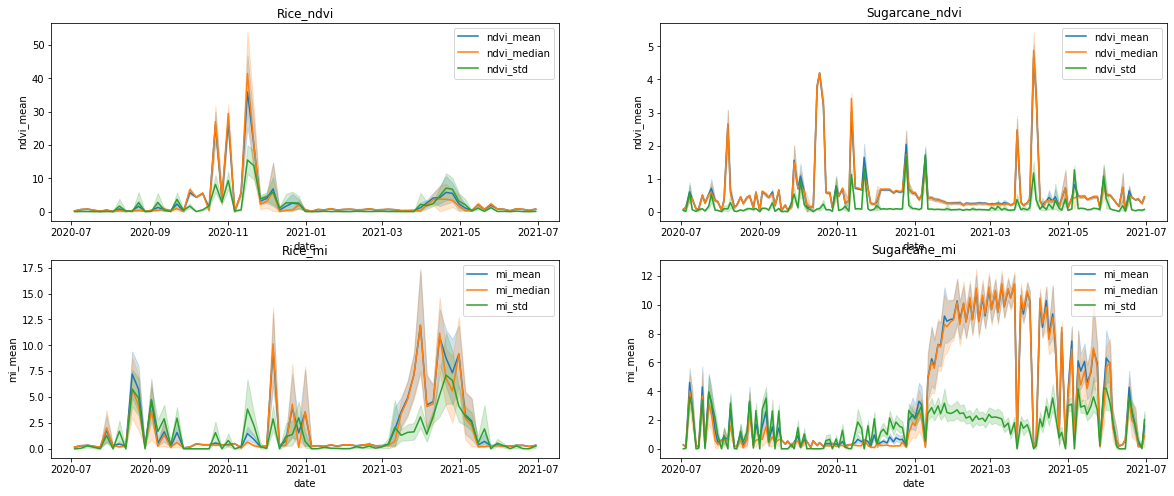

In [7]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sugarcane = df2[df2['target']=='sugarcane']
rice = df2[df2['target']== 'rice_1y']

plt.figure(figsize=(20,8))

# Ndvi Visualization
# Rice
plt.subplot(2, 2, 1)
sns.lineplot(x = "date", y = "ndvi_mean", data = rice, palette = 'blue',label = 'ndvi_mean')
sns.lineplot(x = "date", y = "ndvi_median", data = rice,palette = 'orange',label = 'ndvi_median')
sns.lineplot(x = "date", y = "ndvi_std", data = rice,palette = 'green',label = 'ndvi_std')
plt.title('Rice_ndvi')
# Sugarcane
plt.subplot(2, 2, 2)
sns.lineplot(x = "date", y = "ndvi_mean", data = sugarcane, palette = 'blue',label = 'ndvi_mean')
sns.lineplot(x = "date", y = "ndvi_median", data = sugarcane,palette = 'orange',label = 'ndvi_median')
sns.lineplot(x = "date", y = "ndvi_std", data = sugarcane,palette = 'green',label = 'ndvi_std')
plt.title('Sugarcane_ndvi')

# mi Visualization
# Rice
plt.subplot(2, 2, 3)
sns.lineplot(x = "date", y = "mi_mean", data = rice, palette = 'blue',label = 'mi_mean')
sns.lineplot(x = "date", y = "mi_median", data = rice,palette = 'orange',label = 'mi_median')
sns.lineplot(x = "date", y = "mi_std", data = rice,palette = 'green',label = 'mi_std')
plt.title('Rice_mi')
# Sugarcane
plt.subplot(2, 2, 4)
sns.lineplot(x = "date", y = "mi_mean", data = sugarcane, palette = 'blue',label = 'mi_mean')
sns.lineplot(x = "date", y = "mi_median", data = sugarcane,palette = 'orange',label = 'mi_median')
sns.lineplot(x = "date", y = "mi_std", data = sugarcane,palette = 'green',label = 'mi_std')
plt.title('Sugarcane_mi')

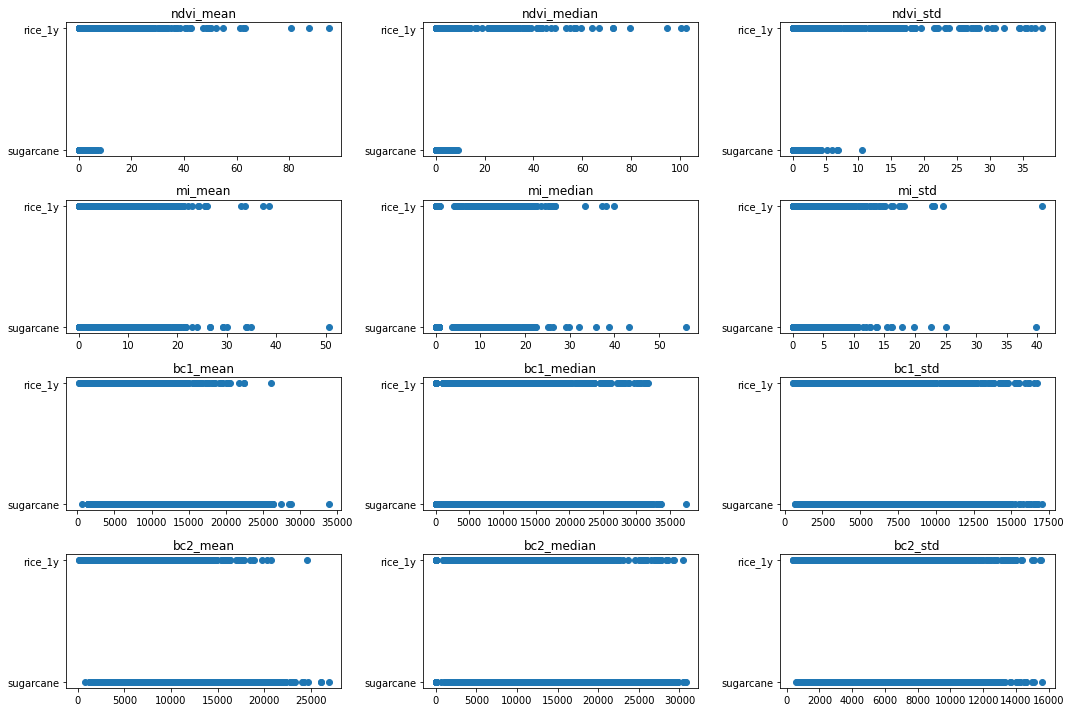

In [9]:
X = df2.drop(columns=['target','date','month','file_id'])
y = df2['target']

fig, ax = plt.subplots(4, 3, figsize=(15,10), tight_layout=True, )

#Ndvi
ax[0,0].scatter(X.ndvi_mean, y)
ax[0,0].set_title('ndvi_mean')
ax[0,1].scatter(X.ndvi_median, y)
ax[0,1].set_title('ndvi_median')
ax[0,2].scatter(X.ndvi_std, y)
ax[0,2].set_title('ndvi_std')

#mi
ax[1,0].scatter(X.mi_mean, y)
ax[1,0].set_title('mi_mean')
ax[1,1].scatter(X.mi_median, y)
ax[1,1].set_title('mi_median')
ax[1,2].scatter(X.mi_std, y)
ax[1,2].set_title('mi_std')

#Cb1
ax[2,0].scatter(X.bc1_mean, y)
ax[2,0].set_title('bc1_mean')
ax[2,1].scatter(X.bc1_median, y)
ax[2,1].set_title('bc1_median')
ax[2,2].scatter(X.bc1_std, y)
ax[2,2].set_title('bc1_std')

#Cb2
ax[3,0].scatter(X.bc2_mean, y)
ax[3,0].set_title('bc2_mean')
ax[3,1].scatter(X.bc2_median, y)
ax[3,1].set_title('bc2_median')
ax[3,2].scatter(X.bc2_std, y)
ax[3,2].set_title('bc2_std')

plt.show()

# Prevent Data Leakage 

In [10]:
#GroupShuffleSplit
from sklearn.model_selection import GroupShuffleSplit
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df2, groups=df2['file_id']))
train = df2.iloc[train_inds]
test = df2.iloc[test_inds]

In [11]:
print(train.shape, test.shape)

(6033, 58) (1748, 58)


In [12]:
A = train.file_id.unique()
B = test.file_id.unique()
bool(set(A).intersection(B))

False

In [13]:
# smote = SMOTE(random_state = 11)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [14]:
X_train = train.drop(columns = ['target','date','file_id'])
y_train= train['target']

X_test = test.drop(columns = ['target','date','file_id'])
y_test = test['target']

# Baseline Model 

In [15]:
#Cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=2000000)
scores = cross_val_score(logreg, X_train, y_train, cv=5)
scores.mean()

/Users/Pinku/.pyenv/versions/3.8.6/envs/business_opt_in_agriculture/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Pinku/.pyenv/versions/3.8.6/envs/business_opt_in_agriculture/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

0.8911059175264248

# Learning Curve

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt

In [18]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=1)

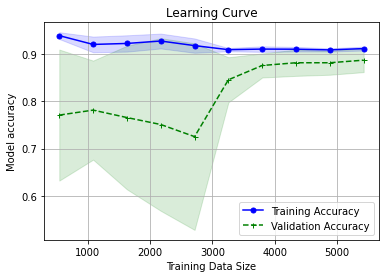

In [20]:
pipeline = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, max_iter=10000))
#
# Use learning curve to get training and test scores along with train sizes
#
train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)

#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Pipeline KNN model 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pipe = Pipeline([('scaler', RobustScaler()),('pca', PCA()),('knn', KNeighborsClassifier(n_neighbors=4, leaf_size = 1, p = 1))])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

pipe.score(X_test,y_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy',accuracy_score(y_test, y_pred))

[[ 242   46]
 [  38 1422]]
Accuracy 0.9519450800915332


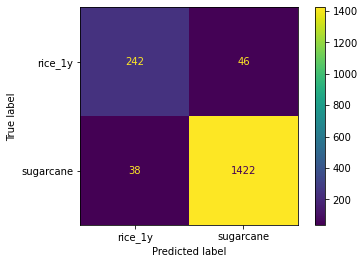

In [22]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe, X_test, y_test)
plt.show()

In [28]:
from sklearn.metrics import precision_score
print(f'Precision_score: {precision_score(y_test, y_pred, average=None)}')

Precision_score: [0.86428571 0.96866485]


In [32]:
from sklearn.metrics import recall_score
# recall_score(y_test, y_pred)
Rice_recall_average = recall_score(y_test, y_pred, average="binary", pos_label="rice_1y")
print(f'Rice recall_average: {Rice_recall_average}')

Rice recall_average: 0.8402777777777778


In [33]:
from sklearn.metrics import recall_score
# recall_score(y_test, y_pred)
Sugarcane_recall_average = recall_score(y_test, y_pred, average="binary", pos_label="sugarcane")
print(f'Sugarcane recall_average: {Sugarcane_recall_average}')

Sugarcane recall_average: 0.9739726027397261


In [31]:
# Save model 
import joblib
# save the model to disk
filename ='pipeline_test2.joblib'
joblib.dump(pipe,filename)
print("saved pipeline.joblib locally")

saved pipeline.joblib locally


In [36]:
folders = ['class0']
class0_df = create_dataset(folders) 
class0_df.head()

<ipython-input-35-0ba1b5f92f23>:15: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (img.read(8)-img.read(4))/(img.read(8) + img.read(4))
<ipython-input-35-0ba1b5f92f23>:23: RuntimeWarning: invalid value encountered in true_divide
  mi = (img.read(8)-img.read(11))/(img.read(8) + img.read(11))
<ipython-input-35-0ba1b5f92f23>:47: RuntimeWarning: invalid value encountered in true_divide
  band_combo_3 = (img.read(3)-img.read(8))/(img.read(3)+img.read(8))


,date,file_id,target,ndvi_mean,ndvi_median,ndvi_std,mi_mean,mi_median,mi_std,bc1_mean,...,b11_mean,b11_median,b11_std,b12_mean,b12_median,b12_std,b13_mean,b13_median,b13_std,month
305,2021-01-16,Name_5e599fc31aed8b0010e82911,class0,0.145215,0.145215,0.008100,16.890828,16.890828,1.193616,4754.500000,...,2235.500000,2235.5,219.500000,1939.500000,1939.5,214.500000,1.000000,1.0,0.000000,1
27,2021-01-01,Name_5e50f4151aed8b0010e82663,class0,0.679298,0.708703,0.083465,0.217436,0.240344,0.080541,5973.407407,...,1930.666667,2151.0,663.817077,1116.462963,1211.0,409.008318,0.907407,1.0,0.289861,1
240,2021-01-26,Name_5e70651d943c0e0011b03a40,class0,0.254231,0.246948,0.038729,9.999839,10.008249,0.815262,4719.300752,...,2771.086466,3726.0,1682.755325,1934.928571,2575.0,1181.690050,0.733083,1.0,0.442349,1
226,2021-01-20,Name_5e4e5b6cec844300113b9cff,class0,0.415800,0.415800,0.025280,0.169898,0.169898,0.013091,3259.000000,...,1355.500000,1355.5,8.500000,1237.000000,1237.0,24.000000,1.000000,1.0,0.000000,1
37,2021-01-31,Name_5e599fc31aed8b0010e82911,class0,0.172901,0.172901,0.064672,16.563931,16.563931,0.406588,4417.000000,...,2427.500000,2427.5,4.500000,2238.000000,2238.0,80.000000,1.000000,1.0,0.000000,1


In [39]:
class0_X = class0_df.drop(columns = ['date', 'file_id','target','bc4_mean',
       'bc4_median', 'bc4_std', 'bc5_mean', 'bc5_median', 'bc5_std'])
class0_X

,ndvi_mean,ndvi_median,ndvi_std,mi_mean,mi_median,mi_std,bc1_mean,bc1_median,bc1_std,bc2_mean,...,b11_mean,b11_median,b11_std,b12_mean,b12_median,b12_std,b13_mean,b13_median,b13_std,month
305,0.145215,0.145215,0.008100,16.890828,16.890828,1.193616,4754.500000,4754.5,28.500000,5014.500000,...,2235.500000,2235.5,219.500000,1939.500000,1939.5,214.500000,1.000000,1.0,0.000000,1
27,0.679298,0.708703,0.083465,0.217436,0.240344,0.080541,5973.407407,6673.0,2028.933523,5581.351852,...,1930.666667,2151.0,663.817077,1116.462963,1211.0,409.008318,0.907407,1.0,0.289861,1
240,0.254231,0.246948,0.038729,9.999839,10.008249,0.815262,4719.300752,6251.5,2859.006389,5433.796992,...,2771.086466,3726.0,1682.755325,1934.928571,2575.0,1181.690050,0.733083,1.0,0.442349,1
226,0.415800,0.415800,0.025280,0.169898,0.169898,0.013091,3259.000000,3259.0,48.000000,3720.500000,...,1355.500000,1355.5,8.500000,1237.000000,1237.0,24.000000,1.000000,1.0,0.000000,1
37,0.172901,0.172901,0.064672,16.563931,16.563931,0.406588,4417.000000,4417.0,266.000000,4851.500000,...,2427.500000,2427.5,4.500000,2238.000000,2238.0,80.000000,1.000000,1.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.046444,0.044611,0.007579,0.065829,0.065715,0.009139,9970.638889,14108.5,6620.754171,9704.083333,...,3142.972222,4448.0,2086.329991,2857.152778,4007.0,1898.432260,0.694444,1.0,0.460642,12
108,0.042398,0.042398,0.008665,0.154185,0.154185,0.002694,8047.500000,8047.5,62.500000,6865.000000,...,2044.000000,2044.0,34.000000,2142.500000,2142.5,27.500000,1.000000,1.0,0.000000,12
118,0.428510,0.428510,0.000180,0.104200,0.104200,0.005627,2959.000000,2959.0,19.000000,3504.000000,...,1388.000000,1388.0,2.000000,1140.000000,1140.0,15.000000,1.000000,1.0,0.000000,12
154,0.421610,0.421610,0.002818,0.170726,0.170726,0.010145,3656.500000,3656.5,76.500000,4266.500000,...,1531.000000,1531.0,2.000000,1434.500000,1434.5,2.500000,1.000000,1.0,0.000000,12


In [41]:
class0_X.keys()

Index(['ndvi_mean', 'ndvi_median', 'ndvi_std', 'mi_mean', 'mi_median',
       'mi_std', 'bc1_mean', 'bc1_median', 'bc1_std', 'bc2_mean', 'bc2_median',
       'bc2_std', 'bc3_mean', 'bc3_median', 'bc3_std', 'b1_mean', 'b1_median',
       'b1_std', 'b2_mean', 'b2_median', 'b2_std', 'b3_mean', 'b3_median',
       'b3_std', 'b4_mean', 'b4_median', 'b4_std', 'b5_mean', 'b5_median',
       'b5_std', 'b6_mean', 'b6_median', 'b6_std', 'b7_mean', 'b7_median',
       'b7_std', 'b8_mean', 'b8_median', 'b8_std', 'b9_mean', 'b9_median',
       'b9_std', 'b10_mean', 'b10_median', 'b10_std', 'b11_mean', 'b11_median',
       'b11_std', 'b12_mean', 'b12_median', 'b12_std', 'b13_mean',
       'b13_median', 'b13_std', 'month'],
      dtype='object')

In [52]:
# class0_X = class0_df.drop(columns = ['date', 'file_id','target'])
# class0_y = class0_df.target

In [42]:
y_pred_class0 = pipe.predict(class0_X)
y_pred_class0

array(['sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'rice_1y', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'rice_1y', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'rice_1y', 'sugarcane',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'rice_1y', 'sugarcane', 'sugarcane', 'sugarcane',
       'sugarcane', 'rice_1y', 'sugarcane', 'sugarcane', 'sugarcane',
  

In [43]:
import numpy as np
(unique, counts) = np.unique(y_pred_class0, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([['rice_1y', 42],
       ['sugarcane', 264]], dtype=object)

In [44]:
folders = ['class1']
class1_df = create_dataset(folders) 
class1_df

<ipython-input-35-0ba1b5f92f23>:15: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (img.read(8)-img.read(4))/(img.read(8) + img.read(4))
<ipython-input-35-0ba1b5f92f23>:23: RuntimeWarning: invalid value encountered in true_divide
  mi = (img.read(8)-img.read(11))/(img.read(8) + img.read(11))
<ipython-input-35-0ba1b5f92f23>:47: RuntimeWarning: invalid value encountered in true_divide
  band_combo_3 = (img.read(3)-img.read(8))/(img.read(3)+img.read(8))


,date,file_id,target,ndvi_mean,ndvi_median,ndvi_std,mi_mean,mi_median,mi_std,bc1_mean,...,b11_mean,b11_median,b11_std,b12_mean,b12_median,b12_std,b13_mean,b13_median,b13_std,month
249,2021-01-29,Name_5ec4a0aa70bb79001069c2e5,class1,0.843866,0.862159,0.076420,0.483743,0.319597,1.444111,4338.120000,...,1228.505000,1464.0,691.155487,674.430000,780.5,396.033625,0.778333,1.0,0.415368,1
297,2021-01-06,Name_5ec4a0aa70bb79001069c2e5,class1,0.702630,0.719340,0.061215,0.473262,0.240357,1.912405,4863.186667,...,1451.983333,1801.0,790.276435,844.108333,1032.0,465.531342,0.778333,1.0,0.415368,1
292,2021-01-11,Name_5e90a73162e2380012e08dcd,class1,0.634059,0.638693,0.050533,0.422094,0.164924,1.699259,1281.321377,...,451.970588,0.0,924.565147,253.974892,0.0,522.230705,0.193687,0.0,0.395187,1
272,2021-01-31,Name_5eaf9030359f990010fd8204,class1,0.301172,0.326703,0.109395,7.617678,12.207999,6.198905,6272.133333,...,2690.333333,2670.0,91.410187,2087.933333,2063.0,171.635842,1.000000,1.0,0.000000,1
262,2021-01-16,Name_5ebb4a77359f990010fd884f,class1,0.616209,0.633196,0.062682,0.743580,0.172839,2.775724,4217.112821,...,1482.194872,1881.0,860.585625,836.261538,1040.0,498.182464,0.758974,1.0,0.427706,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,2020-12-30,Name_5ec4a0aa70bb79001069c2e5,class1,0.774787,0.804663,0.083141,0.769799,0.258456,2.880909,4545.530000,...,1393.610000,1698.5,769.358608,757.316667,895.5,427.700448,0.778333,1.0,0.415368,12
270,2020-12-05,Name_5ec4a0a870bb79001069c2e3,class1,0.462395,0.416316,0.220736,6.369494,9.002926,5.838656,2391.825658,...,1023.573465,0.0,1398.839894,752.172697,0.0,1117.821924,0.376096,0.0,0.484405,12
312,2020-12-27,Name_5e90a73162e2380012e08dcd,class1,0.641827,0.648781,0.065960,0.391576,0.169465,1.645262,1264.398852,...,433.999283,0.0,888.262771,228.550933,0.0,471.156377,0.193687,0.0,0.395187,12
157,2020-12-30,Name_5ec4a0a870bb79001069c2e3,class1,0.536865,0.555582,0.090188,1.687962,0.179575,4.039918,2635.368969,...,923.697368,0.0,1200.041318,512.343750,0.0,684.926599,0.376096,0.0,0.484405,12


In [46]:
class1_X = class1_df.drop(columns = ['date', 'file_id','target','bc4_mean',
       'bc4_median', 'bc4_std', 'bc5_mean', 'bc5_median', 'bc5_std'])
y_pred_class1 = pipe.predict(class1_X)
y_pred_class1

array(['sugarcane', 'sugarcane', 'rice_1y', 'sugarcane', 'sugarcane',
       'rice_1y', 'sugarcane', 'sugarcane', 'sugarcane', 'rice_1y',
       'sugarcane', 'sugarcane', 'sugarcane', 'rice_1y', 'sugarcane',
       'rice_1y', 'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane',
       'rice_1y', 'sugarcane', 'sugarcane', 'rice_1y', 'rice_1y',
       'sugarcane', 'rice_1y', 'rice_1y', 'rice_1y', 'sugarcane',
       'sugarcane', 'sugarcane', 'rice_1y', 'sugarcane', 'rice_1y',
       'sugarcane', 'rice_1y', 'rice_1y', 'rice_1y', 'sugarcane',
       'sugarcane', 'sugarcane', 'rice_1y', 'sugarcane', 'rice_1y',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'rice_1y',
       'rice_1y', 'rice_1y', 'sugarcane', 'rice_1y', 'rice_1y',
       'sugarcane', 'sugarcane', 'sugarcane', 'sugarcane', 'rice_1y',
       'rice_1y', 'rice_1y', 'sugarcane', 'rice_1y', 'rice_1y', 'rice_1y',
       'sugarcane', 'sugarcane', 'rice_1y', 'rice_1y', 'sugarcane',
       'rice_1y', 'sugarcane', 'sugarcane

In [47]:
import numpy as np
(unique, counts) = np.unique(y_pred_class1, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([['rice_1y', 184],
       ['sugarcane', 276]], dtype=object)